In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-feb-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2022/train.csv
/kaggle/input/tabular-playground-series-feb-2022/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

sns.set_style('darkgrid')

In [3]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2022/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2022/test.csv')

In [4]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [5]:
print("Train Dimensions:", train_df.shape)
print("Test Dimensions:", test_df.shape)

Train Dimensions: (200000, 288)
Test Dimensions: (100000, 287)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 288 entries, row_id to target
dtypes: float64(286), int64(1), object(1)
memory usage: 439.5+ MB


In [7]:
train_df.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


In [8]:
train_df.describe()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
count,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05
mean,99999.500000,6.421457e-07,-0.000003,-0.000014,-0.000010,0.000005,0.000025,0.000014,-0.000009,-0.000028,...,0.000135,0.000348,0.000253,0.000464,0.000581,0.000379,0.000062,8.982134e-05,1.170014e-04,2.215407e-07
std,57735.171256,8.654927e-05,0.000132,0.000287,0.000436,0.000683,0.000869,0.000775,0.000441,0.000107,...,0.000711,0.001117,0.000914,0.001238,0.001528,0.001182,0.000466,5.475606e-04,6.788277e-04,2.050081e-05
min,0.000000,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
25%,49999.750000,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
50%,99999.500000,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000237,-0.000199,-0.000114,-0.000043,...,0.000014,0.000064,0.000047,0.000124,0.000114,0.000043,-0.000010,4.632568e-07,4.632568e-07,-9.536743e-07
75%,149999.250000,-9.536743e-07,-0.000003,-0.000013,-0.000004,-0.000011,0.000003,-0.000030,0.000004,-0.000028,...,0.000111,0.000463,0.000297,0.000684,0.000774,0.000365,0.000030,6.046326e-05,6.946326e-05,-9.536743e-07
max,199999.000000,9.999046e-03,0.009990,0.009957,0.009886,0.019800,0.019760,0.019800,0.009886,0.009957,...,0.019957,0.019914,0.019957,0.019914,0.019914,0.019957,0.009990,9.990463e-03,1.999046e-02,9.990463e-04


In [9]:
print("Number of missing values in train set: ", train_df.isna().sum().sum())
print("Number of missing values in test set: ", test_df.isna().sum().sum())

Number of missing values in train set:  0
Number of missing values in test set:  0


In [10]:
targets = train_df['target']
bacteria_counts = targets.value_counts()
bacteria_counts = bacteria_counts.reset_index().rename(columns={"index":"BacteriaSpecies", "target":"Count"})
bacteria_counts.set_index("BacteriaSpecies")

,Count
BacteriaSpecies,
Bacteroides_fragilis,20139
Streptococcus_pyogenes,20076
Streptococcus_pneumoniae,20074
Campylobacter_jejuni,20063
Salmonella_enterica,20030
Escherichia_coli,19958
Enterococcus_hirae,19947
Escherichia_fergusonii,19937
Staphylococcus_aureus,19929


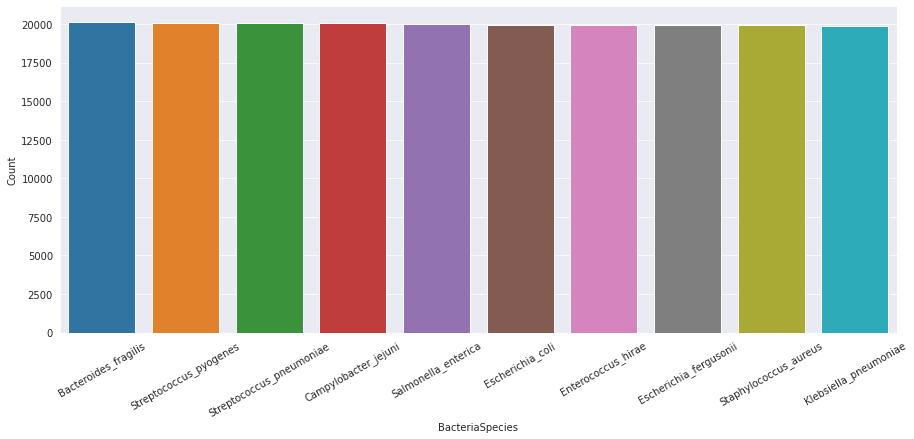

In [11]:
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x = "BacteriaSpecies", y="Count", data = bacteria_counts)
plt.xticks(rotation=30);

In [12]:
train_cols = list(train_df.columns.drop(['row_id','target']))

In [13]:
def bias(w,x,y,z):
    b = 1/4**10 * (np.math.factorial(10)/(np.math.factorial(w)*np.math.factorial(x)*np.math.factorial(y)*np.math.factorial(z)))
    return b

In [14]:
def calc_bias(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    b = bias(w,x,y,z)
    return b

In [15]:
train_df_bias = pd.DataFrame({col: (((train_df[col] + calc_bias(col))*10**6).round().astype(int)) for col in train_cols})
test_df_bias = pd.DataFrame({col: (((test_df[col] + calc_bias(col))*10**6).round().astype(int)) for col in train_cols})
train_df_bias.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1000,0,1000,0,0,0,0,...,0,0,0,1000,1000,0,0,0,0,0
2,0,8,50,243,468,510,443,239,44,3,...,85,170,91,167,192,115,20,18,29,2
3,1,4,55,359,692,762,596,311,40,3,...,111,237,143,266,288,196,31,25,56,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
def gcd_of_all(df_i):
    gcd = df_i[train_cols[0]]
    for col in train_cols[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

train_df_bias['gcd'] = gcd_of_all(train_df_bias)
train_df['gcd'] = gcd_of_all(train_df_bias)
test_df['gcd'] = gcd_of_all(test_df_bias)

In [17]:
gcd_counts = train_df["gcd"].value_counts().reset_index().rename(columns={"gcd":"train_count", "index":"gcd"}).sort_values(by="gcd").set_index("gcd")
gcd_counts["test_count"] = test_df["gcd"].value_counts()
gcd_counts["train_perc"] = 100 * gcd_counts["train_count"]/gcd_counts["train_count"].sum()
gcd_counts["test_perc"] = 100 * gcd_counts["test_count"]/gcd_counts["test_count"].sum()
gcd_counts

,train_count,test_count,train_perc,test_perc
gcd,,,,
1,49969,25208,24.9845,25.208
10,50002,24951,25.0010,24.951
1000,50058,24930,25.0290,24.930
10000,49971,24911,24.9855,24.911


In [18]:
train_df_bias["target"] = train_df['target']

GCD:  1  explained variance ratio (first two components):  [0.86093819 0.10453706]
GCD:  10  explained variance ratio (first two components):  [0.85463457 0.10358183]
GCD:  1000  explained variance ratio (first two components):  [0.46244238 0.09228579]
GCD:  10000  explained variance ratio (first two components):  [0.13602481 0.09592903]


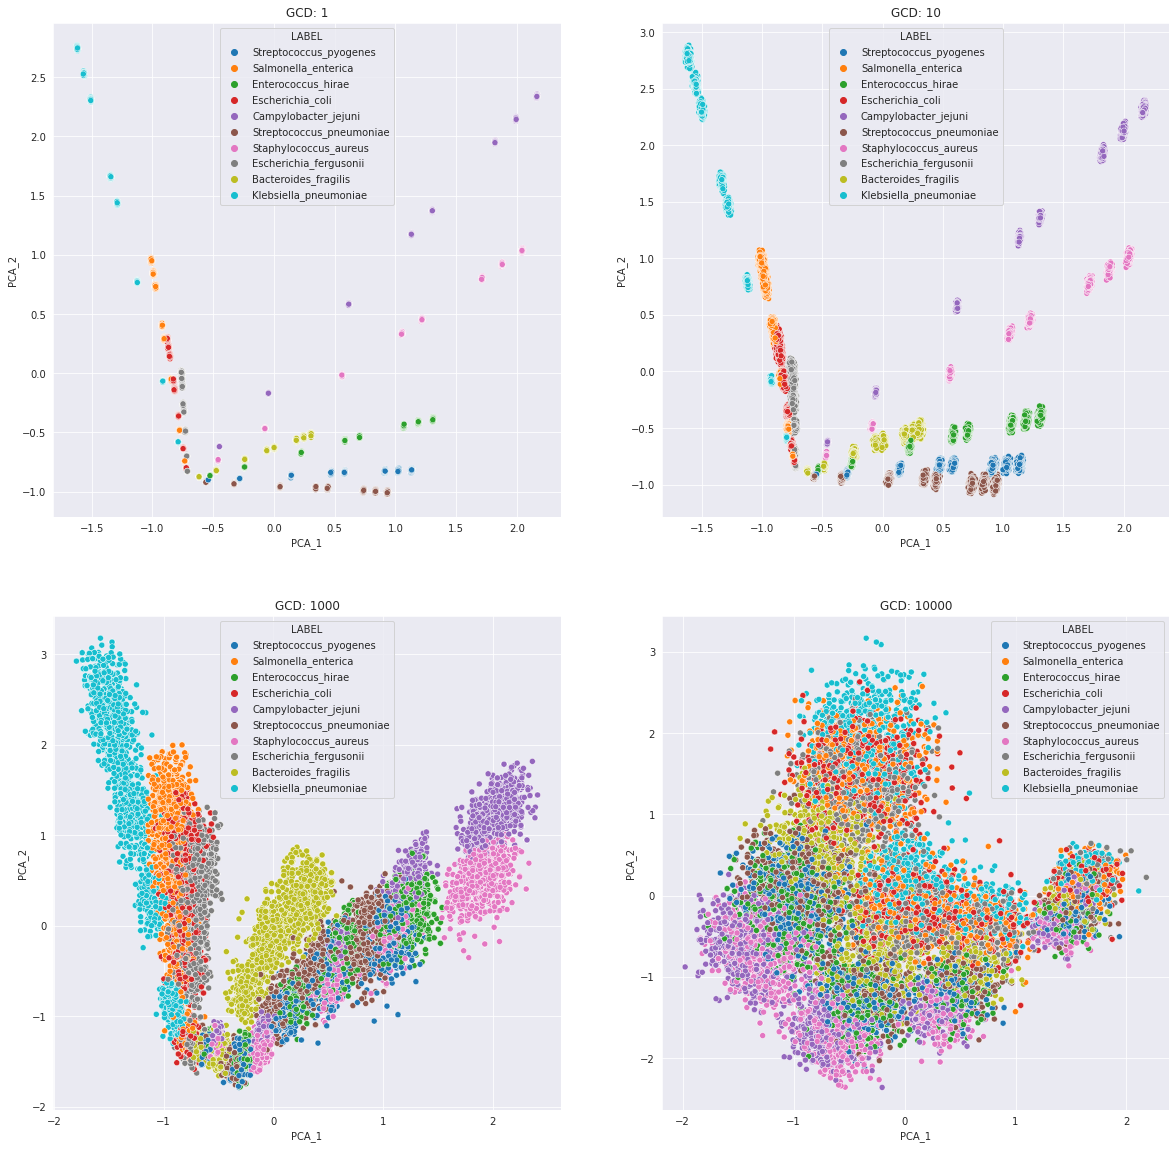

In [19]:
plt.figure(figsize=(20, 20))

for i,gcd in enumerate([1,10,1000,10000]):
    pca = PCA(n_components = 2, random_state = 10, whiten = True)
    pca.fit(train_df_bias[train_df_bias["gcd"] == gcd][train_cols])

    X_PCA = pca.transform(train_df_bias[train_df_bias["gcd"] == gcd][train_cols])

    # Percentage of variance explained for each components
    print( "GCD: ", gcd, " explained variance ratio (first two components): ", pca.explained_variance_ratio_)

    PCA_df = pd.DataFrame({"PCA_1" : X_PCA[:,0], "PCA_2" : X_PCA[:,1], "LABEL":train_df_bias[train_df_bias["gcd"] == gcd]["target"]})
    
    ax = plt.subplot(2, 2, i + 1)
    plt.title("GCD: " + str(gcd))
    sns.scatterplot(data = PCA_df, x = "PCA_1", y = "PCA_2", hue = "LABEL", hue_order = train_df_bias["target"].unique())